In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [70]:
from expertise.data import load_all_predictors, load_feature_data
from expertise.predictors import train_boosted, create_predicted_dataframe, train_regression_tree, predict_aggregate, train_random_predictor, train_adaboost
from expertise.multical import assess_callibration, assess_callibration_no_split
from expertise.utils import subsample_rows

## Setup Data

In [4]:
max_depth = 5
bins = 10

In [5]:
tidy = load_all_predictors()

In [6]:
x_train, y_train, x_train_id, x_test, y_test, x_test_id = load_feature_data()
test_predictions = train_boosted(x_train,y_train,x_test,max_depth)
m = create_predicted_dataframe(test_predictions,x_test_id,bins)
tidy = tidy.merge(m, on='file_id', how='left')
tidy['boosted_pred'] = tidy['mc_pred'].round()

LS:  35%|███▌       35/100 00:17, Training Error=0.0085429

Early Termination at round: 36
Memory released!


In [15]:
y_hat = train_boosted(x_train,y_train,x_train,max_depth)
mean_squared_error(y_hat,y_train)

LS:  37%|███▋       37/100 00:16, Training Error=0.0063596

Early Termination at round: 38
Memory released!


0.0063596445568771505

In [13]:
y_hat = train_regression_tree(x_train,y_train,x_train,max_depth)
mean_squared_error(y_hat,y_train)

0.0

In [11]:
y_hat = train_adaboost(x_train,y_train,x_train,max_depth)
mean_squared_error(y_hat,y_train)

0.17911124601719774

In [8]:
tidy

,file_id,human.pred.c,human.pred.t12,human.pred.t4,human.pred.t8,pred_esc_random_forest,true_esc,pred_esc_naive bayes,pred_esc_logistic_regression,pred_esc_linear_svm,pred_esc_gradient_boosting,mc_pred,bin,boosted_pred
0,321932871341684,1,1,1,1,0,0,1,1,1,1,1.000000,10,1.0
1,321933198008318,1,1,0,1,1,1,1,0,0,0,0.003753,1,0.0
2,324207107780927,1,0,0,0,1,0,1,1,1,1,0.000000,0,0.0
3,338180983050206,1,0,0,0,1,0,1,1,1,1,1.000000,10,1.0
4,338181036383534,0,1,1,0,1,0,1,1,1,1,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,1036634413051119,0,0,0,0,0,0,0,0,0,1,0.003753,1,0.0
856,1036635499717677,0,1,1,1,0,0,0,0,0,0,0.016830,1,0.0
857,1038831612831399,0,0,0,0,0,0,0,0,0,0,0.009680,1,0.0
858,1038833189497908,1,1,0,0,1,0,1,1,1,1,0.009680,1,0.0


## Accuracy of Different Predictors

In [16]:
rf = assess_callibration(tidy,"pred_esc_random_forest","pred_esc_random_forest","true_esc")
lr = assess_callibration(tidy,"pred_esc_logistic_regression","pred_esc_logistic_regression","true_esc")
svm = assess_callibration(tidy,"pred_esc_linear_svm","pred_esc_linear_svm","true_esc")
gb = assess_callibration(tidy,"pred_esc_gradient_boosting","pred_esc_gradient_boosting","true_esc")
boosted = assess_callibration(tidy,"boosted_pred","boosted_pred","true_esc")
rf,lr,svm,gb,boosted

(0.686046511627907,
 0.6813953488372093,
 0.6976744186046512,
 0.6976744186046512,
 0.6906976744186047)

In [10]:
rf = assess_callibration(tidy,"human.pred.t12","pred_esc_random_forest","true_esc")
lr = assess_callibration(tidy,"human.pred.t12","pred_esc_logistic_regression","true_esc")
svm = assess_callibration(tidy,"human.pred.t12","pred_esc_linear_svm","true_esc")
gb = assess_callibration(tidy,"human.pred.t12","pred_esc_gradient_boosting","true_esc")
boosted = assess_callibration(tidy,"human.pred.t12","boosted_pred","true_esc")
rf,lr,svm,gb,boosted

(0.7255813953488373,
 0.7186046511627906,
 0.7255813953488373,
 0.7395348837209301,
 0.7046511627906977)

## Compare \mathcal{F}

In [72]:
for global_gamma in [0.01,0.02,0.05,0.1]:
    test_predictions = subsample_rows(train_boosted(x_train,y_train,x_test,max_depth,global_gamma).round(),tidy,x_test_id)
    tidy['boosted_pred'] = test_predictions
    boosted_predictor = assess_callibration_no_split(tidy,"human.pred.t12","boosted_pred","true_esc")
    print(global_gamma,boosted_predictor)

LS:  35%|███▌       35/100 00:18, Training Error=0.0078963

Early Termination at round: 36
Memory released!
0.01 0.7348837209302326



LS:  32%|███▏       32/100 00:19, Training Error=0.0134308

Early Termination at round: 33
Memory released!
0.02 0.7267441860465116



LS:  15%|█▌         15/100 00:25, Training Error=0.0736541

Early Termination at round: 16
Memory released!
0.05 0.7430232558139535



LS:   2%|▏          2/100 00:42, Training Error=0.1471003

Early Termination at round: 3
Memory released!
0.1 0.7593023255813954


In [73]:
score_by_rt = []

for rt in range(4):
    scores = []
    for i in range(100):

        tidy['cluster'] = train_random_predictor(tidy['true_esc'],0.7)
        random_predictor = assess_callibration_no_split(tidy,"cluster","rt_{}".format(rt+1),"true_esc")
        scores.append(random_predictor)
    score_by_rt.append(np.mean(scores))
score_by_rt

[0.7414186046511627, 0.7375, 0.737825581395349, 0.7415348837209302]

In [74]:
np.array([assess_callibration_no_split(tidy,"rt_{}".format(rt+1),"rt_{}".format(rt+1),"true_esc") for rt in range(4)]),np.array(score_by_rt)

(array([0.69651163, 0.68837209, 0.68604651, 0.69418605]),
 array([0.7414186 , 0.7375    , 0.73782558, 0.74153488]))

In [75]:
np.array([assess_callibration_no_split(tidy,"rt_{}".format(rt+1),"rt_{}".format(rt+1),"true_esc") for rt in range(4)])-np.array(score_by_rt)

array([-0.04490698, -0.04912791, -0.05177907, -0.04734884])

In [79]:
score_by_rt = []
true_score = []

for rt in [0.66,0.67,0.68,0.69]:
    scores = []
    tidy['rt'] = train_random_predictor(tidy['true_esc'],rt)
    for i in range(250):

        tidy['cluster'] = train_random_predictor(tidy['true_esc'],0.7)
        random_predictor = assess_callibration_no_split(tidy,"cluster","rt","true_esc")
        scores.append(random_predictor)
    score_by_rt.append(np.mean(scores))
    true_score.append(assess_callibration_no_split(tidy,"rt","rt","true_esc"))
    print(np.std(scores))
score_by_rt

0.0075370367294380295
0.008002725333513332
0.007646218802744814
0.007638264380566503


[0.740186046511628, 0.7496372093023256, 0.7549348837209302, 0.7580046511627908]

In [80]:
np.array(true_score)-np.array(score_by_rt)

array([-0.08088372, -0.07986977, -0.07586512, -0.06846977])

In [68]:
sum(tidy['rt'] == tidy['true_esc'])/len(tidy)

0.6895348837209302

In [64]:
np.array(true_score)

array([0.62790698, 0.62790698, 0.6744186 , 0.70465116])

In [81]:
scores = []
for i in range(100):

    tidy['cluster'] = train_random_predictor(tidy['true_esc'],0.7)
    random_predictor = assess_callibration_no_split(tidy,"cluster","boosted_pred","true_esc")
    scores.append(random_predictor)

assess_callibration_no_split(tidy,"boosted_pred","boosted_pred","true_esc"),np.mean(scores)

(0.744186046511628, 0.7688604651162793)

In [93]:
scores = []
for i in range(100):
    tidy['rt'] = train_random_predictor(tidy['true_esc'],0.744)
    tidy['cluster'] = train_random_predictor(tidy['true_esc'],0.7)
    random_predictor = assess_callibration_no_split(tidy,"cluster","rt","true_esc")
    scores.append(random_predictor)

In [94]:
np.mean(scores), assess_callibration_no_split(tidy,"boosted_pred","boosted_pred","true_esc")

0.7814651162790698

In [82]:
assess_callibration_no_split(tidy,"boosted_pred","boosted_pred","true_esc")

0.744186046511628

In [35]:
assess_callibration(tidy,"human.pred.t12","rt_1","true_esc")

0.6906976744186046

In [37]:
assess_callibration(tidy,"human.pred.t12","boosted_pred","true_esc")

0.7162790697674419

In [11]:
boosted_predictor = assess_callibration(tidy,"human.pred.t12","bin","true_esc")
boosted_predictor

0.7046511627906977

In [28]:
num_trees = 10
num_clusters = 2
for i in range(1,num_trees+1):
    tidy['rt_{}'.format(i)] = subsample_rows(train_regression_tree(x_train,y_train,x_test,i),tidy,x_test_id)
tidy['cluster'] = predict_aggregate(tidy[['rt_{}'.format(i) for i in range(1,num_trees+1)]].to_numpy(),num_clusters)

In [13]:
top_k_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
top_k_predictor

0.6767441860465115

In [14]:
pred_by_trees = []
for num_trees in range(2,11):
    num_clusters = 2
    for i in range(1,num_trees+1):
        tidy['rt_{}'.format(i)] = subsample_rows(train_regression_tree(x_train,y_train,x_test,i),tidy,x_test_id)
    tidy['cluster'] = predict_aggregate(tidy[['rt_{}'.format(i) for i in range(1,num_trees+1)]].to_numpy(),num_clusters)
    top_k_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
    pred_by_trees.append(top_k_predictor)

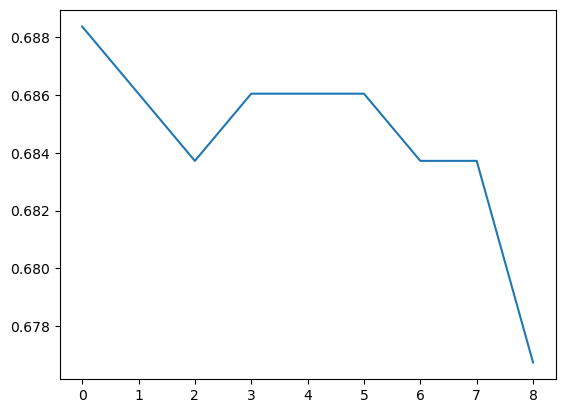

In [15]:
plt.plot(pred_by_trees)

In [16]:
individual_tree_perf = assess_callibration(tidy,"rt_1","rt_1","true_esc")
bagged_trees_perf = assess_callibration(tidy,"cluster","cluster","true_esc")
boosted_trees_perf = assess_callibration(tidy,"boosted_pred","boosted_pred","true_esc")
individual_tree_perf,bagged_trees_perf, boosted_trees_perf

(0.6813953488372093, 0.6581395348837209, 0.6837209302325581)

In [17]:
assess_callibration(tidy,"human.pred.t12","boosted_pred","true_esc")


0.7046511627906977

## Impact of Multicallibration

In [18]:
tidy['cluster'] = train_random_predictor(tidy['true_esc'],0.7)
random_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
random_predictor

0.758139534883721

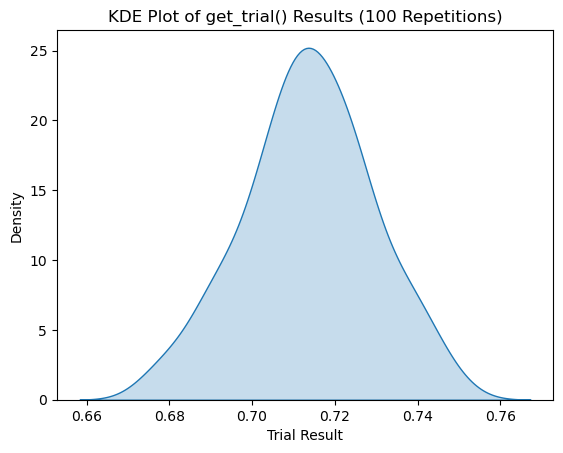

In [19]:
num_trials = 100
accuracy = 0.65
trials = []
for i in range(num_trials):
    tidy['cluster'] = train_random_predictor(tidy['true_esc'],accuracy)
    random_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
    trials.append(random_predictor)
sns.kdeplot(trials, shade=True)
plt.xlabel('Trial Result')
plt.ylabel('Density')
plt.title('KDE Plot of get_trial() Results (100 Repetitions)')
plt.show()

On val 0
On val 1
On val 0
On val 1


On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
O

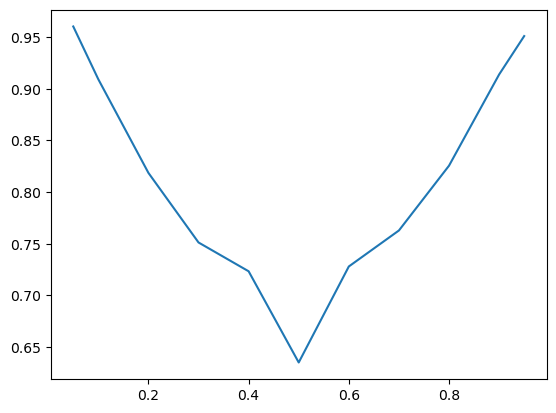

In [17]:
num_trials = 10
x_values = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
y_values = []
for accuracy in x_values:
    trials = []
    for i in range(num_trials):
        tidy['cluster'] = train_random_predictor(tidy['true_esc'],accuracy)
        random_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
        trials.append(random_predictor)
    y_values.append(np.max(trials))

plt.plot(x_values,y_values)

In [23]:
import pandas as pd
pd.crosstab(tidy['true_esc'],tidy['human.pred.t12'])

human.pred.t12,0,1
true_esc,,
0,344,212
1,69,235


In [34]:
data_column = tidy[['human.pred.t12','true_esc']].to_numpy()
new_labels = []
num_mistakes = 0
max_mistakes = int(len(tidy)*0.7)
for i in range(len(data_column)):
    if data_column[i][1] == 1:
        new_labels.append(1)
    elif data_column[i][1] == 0 and data_column[i][0] == 0 and num_mistakes<max_mistakes:
        new_labels.append(1)
    else:
        new_labels.append(0)
tidy['cluster'] = new_labels
assess_callibration(tidy,"human.pred.t12","cluster","true_esc")

0.9046511627906977

In [35]:
num_trials = 100
accuracy = 0.7
trials = []
for i in range(num_trials):
    tidy['cluster'] = train_random_predictor(tidy['true_esc'],accuracy)
    predictors_by_human = [assess_callibration(tidy,"human.pred.t{}".format(i),"cluster","true_esc") for i in [4,8,12]]
    trials.append(predictors_by_human)
trials = np.array(trials)

In [94]:
np.argmax(trials[:,0]),np.argmax(trials[:,1]),np.argmax(trials[:,2])

(62, 35, 62)

In [99]:
np.corrcoef(trials[:,0],trials[:,1])[0,1],np.corrcoef(trials[:,0],trials[:,2])[0,1],np.corrcoef(trials[:,1],trials[:,2])[0,1]

(0.5507097305367171, 0.509824906737115, 0.5345193427372451)

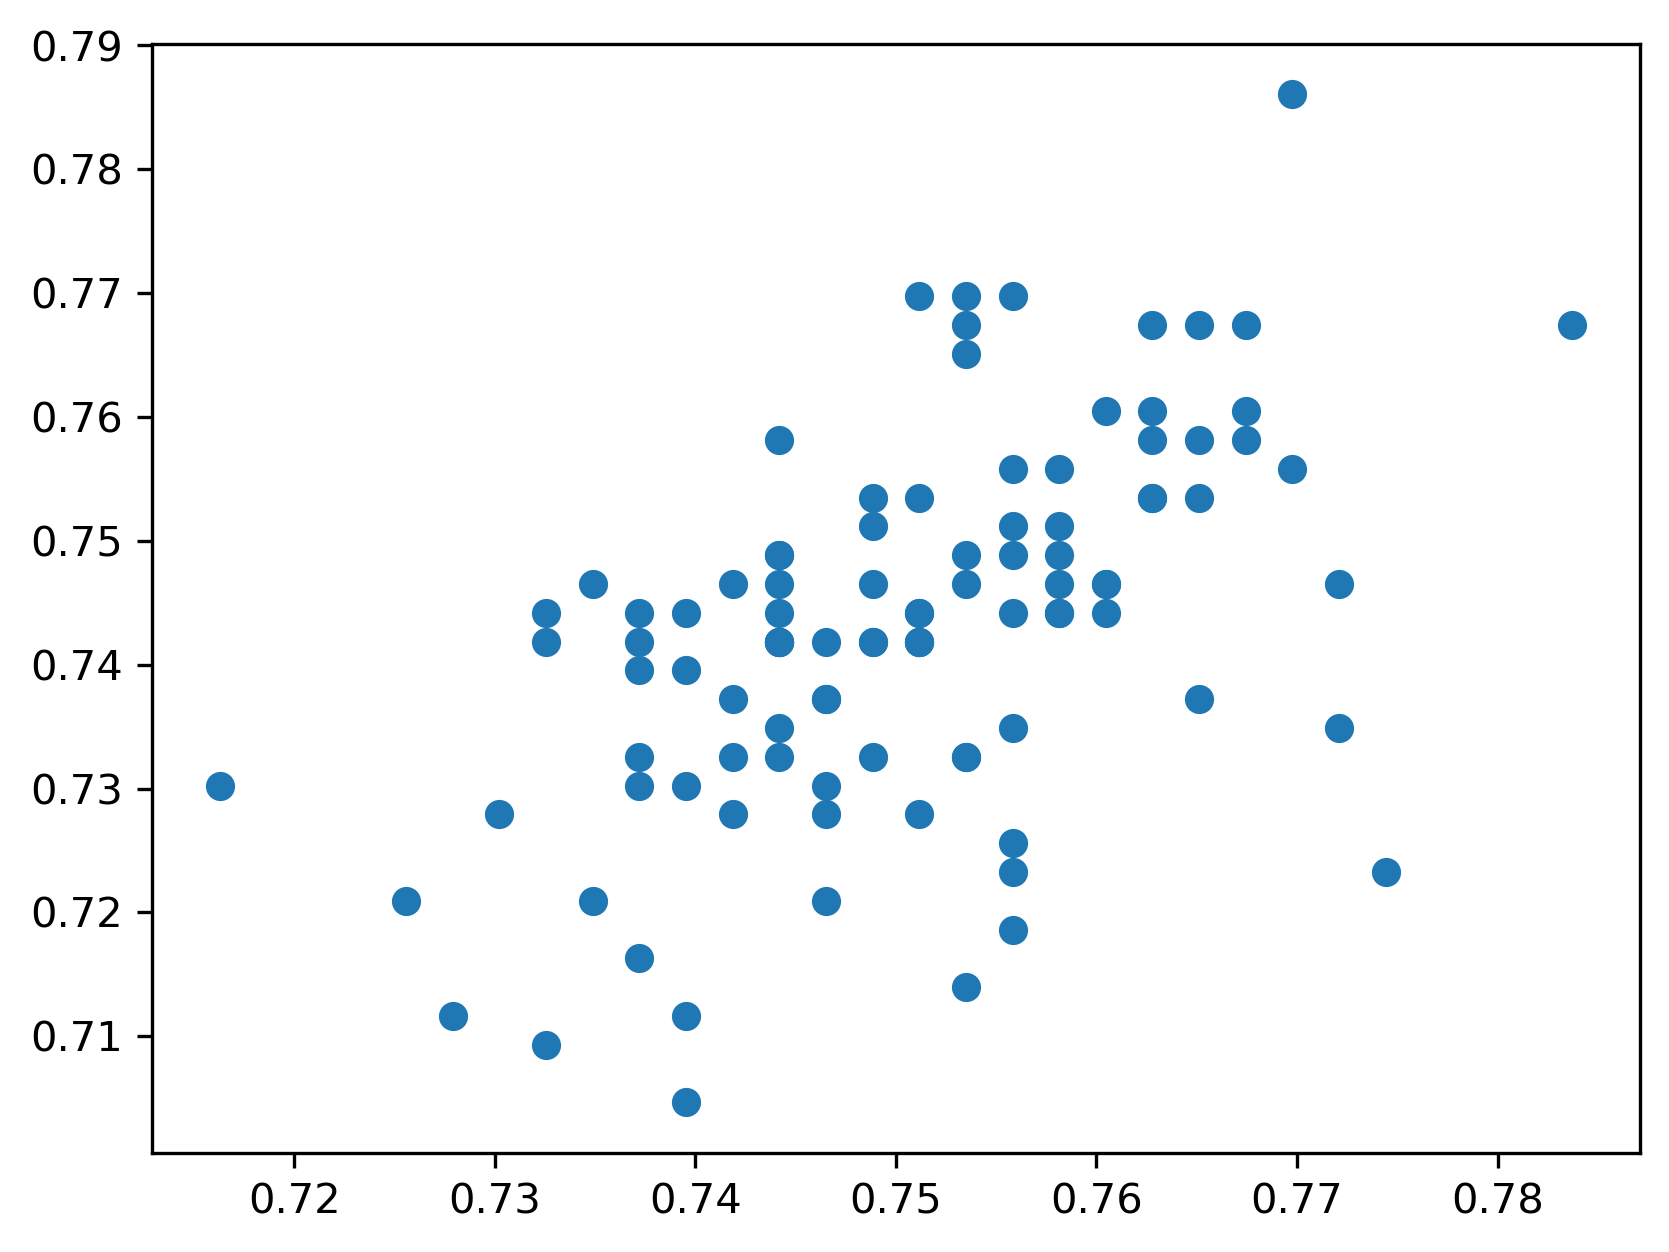

In [100]:
plt.scatter(trials[:,1],trials[:,2])